In [22]:
import mlflow
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import constants as c
torch.cuda.empty_cache()
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm


In [35]:
runs = {
        "florida":
        {
            "CNN": (1, 'e25c6b40324643c3afc1cf42981b11b5'),
            "13x13": (0, 'e1d15a0615ca489aa6a17ec60247d0af'),
            "9x9": (0, '3f48868c52404eb0a833897aa4642871'),
            "5x5": (0, '1824682ae27c48669665cf042052d584'),
            "nf": (0, 'feda42500d2b45549be96f1bf62b0b03')
        },
       "central":
        {
            "CNN": (1, 'fbe44b0423204805bc6af4d7d6ac562e'),
            "13x13": (0, 'bcf7e7cfa8ab4c4196ad6a2bb18e8601'),
            "9x9": (0, '079a94c41ad3482996cc2b9f95adba8d'),
            "5x5": (0, '202ea9f8a73b401fa22e62c24d9ab2d0'),
            "nf": (0, '0c5ee480663f4f9eb7200f8879aa1244')
        },
        "west":
        {
            "CNN": (1, 'f76c0170818244629de4544805f93a59'),
            "13x13": (0, 'c4ec13e65fe74b399fc9e325a9966fef'),
            "9x9": (0, '6abe7a9940c04b47819689070100e5e6'),
            "5x5": (0, '70f5be887eff42e8a216780752644b2f'),
            "nf": (0, 'db9f0fae83c949eaad5d1176a43dae47')
        }
}

region = "west"

results_florida = {}
i = 999

mu, su = c.region_stats_u10[region]
mv, sv = c.region_stats_v10[region]

dsc = xr.open_dataset(f"/home/nannau/deeplearning/data/ground_truth/coarse_validation_{region}.nc")
dsf = xr.open_dataset(f"/home/nannau/deeplearning/data/ground_truth/wrf_validation_{region}.nc")

coarse = torch.from_numpy(dsc.to_array()[0, ...].values).to(c.device).float()
fine = torch.from_numpy(dsf.to_array()[0, ...].values).to(c.device).float()

fake = fine.clone()

aranged = torch.split(torch.arange(coarse.size(0)), 16, dim=0)

results = {}
coarse = torch.from_numpy(dsc.to_array()[0, ...].values).to(c.device).float()

fine = torch.from_numpy(dsf.to_array()[0, ...].values).to(c.device).float()
fake = fine.clone()

# for exp in ["CNN", "nf", "5x5", "9x9", "13x13"]:
enum, hc = runs[region]["nf"]
model_path = f"/home/nannau/deeplearning/experiments/mlflow_experiments/{enum}/{hc}/artifacts"
g_path = model_path+f"/Generator/Generator_{i}"

stds = np.linspace(0, 0.5, 10)
mae = []
testpert = {}
with torch.no_grad():
    for i in range(0, 7):
        if i != 2:
            print(i)
            mae = []
            for s in tqdm.notebook.tqdm(stds):
                fcoarse = coarse.clone()
                G = mlflow.pytorch.load_model(g_path).to(c.device)
                state_dict = mlflow.pytorch.load_state_dict(g_path)
                G.load_state_dict(state_dict)
                p = torch.normal(
                    mean=torch.zeros_like(fcoarse[:, 0, ...]),
                    std=s*torch.ones_like(fcoarse[:, 0, ...])
                )
                fcoarse[:, i, ...] = fcoarse[:, i, ...] + p
                for idx in aranged:
                    fake[idx, ...] = G(fcoarse[idx, ...])
                mae.append(mean_absolute_error(fine.cpu().flatten(), fake.cpu().flatten()))
            testpert[i] = mae

0


/tmp/ipykernel_857742/4017214627.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm_notebook(stds):


  0%|          | 0/10 [00:00<?, ?it/s]

1


/tmp/ipykernel_857742/4017214627.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm_notebook(stds):


  0%|          | 0/10 [00:00<?, ?it/s]

3


/tmp/ipykernel_857742/4017214627.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm_notebook(stds):


  0%|          | 0/10 [00:00<?, ?it/s]

4


/tmp/ipykernel_857742/4017214627.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm_notebook(stds):


  0%|          | 0/10 [00:00<?, ?it/s]

5


/tmp/ipykernel_857742/4017214627.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm_notebook(stds):


  0%|          | 0/10 [00:00<?, ?it/s]

6


/tmp/ipykernel_857742/4017214627.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm_notebook(stds):


  0%|          | 0/10 [00:00<?, ?it/s]

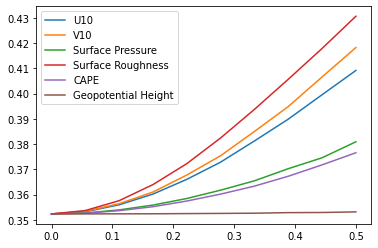

In [36]:
labels = {
    0: "U10",
    1: "V10",
    3: "Surface Pressure",
    4: "Surface Roughness",
    5: "CAPE",
    6: "Geopotential Height",
    
}
for i in range(0, 7):
    if i != 2:
        plt.plot(stds, testpert[i], label=labels[i])
plt.legend()

In [32]:
torch.randn(coarse[idx, ...].size(), 0, 1)

TypeError: randn() received an invalid combination of arguments - got (torch.Size, int, int), but expected one of:
 * (tuple of ints size, *, torch.Generator generator, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [12]:
torch.normal(mean=torch.zeros_like(coarse[idx, ...]), std=0.01*torch.ones_like(coarse[idx, ...]))

tensor([[[[-2.2944e-04,  1.9769e-03, -2.0685e-03,  ...,  1.7979e-02,
            5.9157e-03, -6.7132e-03],
          [ 1.1241e-02, -1.5129e-03, -2.4384e-02,  ...,  7.3624e-03,
           -1.8785e-03, -1.1723e-02],
          [ 1.0835e-02,  2.1507e-02, -2.3964e-03,  ..., -2.5638e-03,
            6.8725e-03,  2.6053e-04],
          ...,
          [-1.7567e-02,  8.4748e-03, -2.1353e-03,  ..., -9.2746e-04,
            8.7766e-03,  2.9054e-03],
          [-2.1284e-03, -1.3576e-02, -3.6697e-03,  ...,  2.1384e-03,
           -9.1927e-03,  2.0291e-02],
          [ 1.4268e-03,  1.7867e-02,  7.8131e-03,  ...,  1.0503e-02,
           -6.1974e-03, -1.1371e-02]],

         [[ 6.6962e-03, -1.0991e-02, -1.4614e-02,  ...,  7.6053e-03,
            3.9354e-03, -9.1818e-03],
          [ 9.3888e-03,  5.3519e-03, -1.3370e-02,  ..., -1.1601e-03,
           -6.0010e-03, -1.1645e-02],
          [ 3.3695e-02, -1.1095e-02, -2.4738e-03,  ..., -1.6405e-02,
            3.0769e-03,  3.4471e-05],
          ...,
     